In [ ]:
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install transformers

In [2]:
import ast
from tqdm.auto import tqdm

In [3]:
!polyglot download sentiment2.ru

[polyglot_data] Downloading package sentiment2.ru to
[polyglot_data]     /root/polyglot_data...


In [4]:
from polyglot.text import Text as T
text = T("А это намного лучше, даже хорошо!")
text.polarity

1.0

In [49]:
from polyglot.text import Text as T
text = T("И это очень раздражает")
text.polarity

-1.0

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn import functional as F
from torch import argmax
from torch import no_grad
from torch import device, cuda

device = device("cuda" if cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sismetanin/rubert-toxic-pikabu-2ch")

model = AutoModelForSequenceClassification.from_pretrained("sismetanin/rubert-toxic-pikabu-2ch").to(device)

text = "На кол её суку,или сначало избить,желательно ногами,тварина"
encoded_input = tokenizer(text, return_tensors='pt').to(device)
with no_grad():
  output = model(**encoded_input)


In [12]:
probabilities = F.softmax(output.logits, dim=-1)
predictions = argmax(probabilities, axis=1)
print(probabilities[0].cpu().numpy(), predictions[0].item())

[0.00525234 0.9947476 ] 1


In [13]:
def is_toxic_comment(model, tokenizer, text: str):
  encoded_input = tokenizer(text, return_tensors='pt').to(device)
  with no_grad():
    output = model(**encoded_input)
  probabilities = F.softmax(output.logits, dim=-1)
  predictions = argmax(probabilities, axis=1)
  return probabilities[0].cpu().numpy(), predictions[0].item()

In [14]:
text = "На кол её суку,или сначало избить,желательно ногами,тварина"
probs, comment_class = is_toxic_comment(model, tokenizer, text)
print(probs)
print('not toxic' if comment_class == 0 else 'toxic')

[0.00525234 0.9947476 ]
toxic


In [15]:
import pandas as pd
import numpy as np

In [115]:
df = pd.read_csv('sport.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         389 non-null    object
 1   num_comments  389 non-null    int64 
 2   link          389 non-null    object
 3   text          389 non-null    object
 4   comments      389 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [ ]:
!pip install natasha

In [18]:
from natasha import (
    Segmenter,
    
    NewsEmbedding,
    NewsMorphTagger,

    Doc
)

In [22]:
class GenderIdentifier:
    
    def __init__(self):
        self.segmenter = Segmenter()
        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)


    def get_gender_from_text(self, news_title):
        doc = Doc(news_title)
        doc.segment(self.segmenter)
        doc.tag_morph(self.morph_tagger)
        is_female = self.is_female(doc)
        return is_female


    def is_female(self, doc):
        fem_count = 0
        masc_count = 0
        for token in doc.tokens:
            if token.pos == 'NOUN' and 'Animacy' in token.feats and  'Anim' == token.feats['Animacy']:                
                if 'Fem' == token.feats['Gender']:
                    fem_count+=1
                elif 'Masc' == token.feats['Gender']:
                    masc_count+=1
            if token.pos == 'VERB' and 'Animacy' in token.feats and 'Gender' in token.feats:
                if 'Fem' == token.feats['Gender']:
                    fem_count+=1
                elif 'Masc' == token.feats['Gender']:
                    masc_count+=1
        return fem_count, masc_count

In [23]:
gend_ident = GenderIdentifier()

In [116]:
toxicity = []
fems = []
mascs = []

for title, comments in tqdm(zip(df.title.to_numpy(), df.comments.to_numpy())):
  fem, masc = gend_ident.get_gender_from_text(title)
  fems.append(fem)
  mascs.append(masc)
  
  avg_prob = []  
  for comment in ast.literal_eval(comments):
    try:
      probs, comment_class = is_toxic_comment(model, tokenizer, comment)
    except:
        pass
    else:
      avg_prob.append(probs)
  if len(avg_prob) > 0:
    avg_prob = np.average(avg_prob, axis=0)
    toxicity.append(list(avg_prob))
  else:
    toxicity.append([0.0, 0.0])

print(toxicity)
print(fems)
print(mascs)

0it [00:00, ?it/s]

[[0.4604861, 0.5395138], [0.89191186, 0.10808822], [0.6519997, 0.3480003], [0.37079102, 0.629209], [0.9971236, 0.002876417], [0.9920704, 0.00792965], [0.65252054, 0.34747943], [0.04888449, 0.95111555], [0.88020056, 0.11979946], [0.20660943, 0.7933906], [0.59496635, 0.40503368], [0.45025483, 0.5497452], [0.517635, 0.48236498], [0.97777945, 0.02222056], [0.06495988, 0.93504006], [0.0, 0.0], [0.56192803, 0.43807197], [0.5584275, 0.44157246], [0.9912607, 0.008739306], [0.38151592, 0.6184841], [0.7803817, 0.21961835], [0.62983453, 0.37016553], [0.63104415, 0.36895588], [0.6586129, 0.34138706], [0.99729127, 0.0027087128], [0.52989197, 0.47010797], [0.30372366, 0.69627637], [0.030755682, 0.9692443], [0.67357105, 0.32642892], [0.5216571, 0.4783429], [0.77955943, 0.22044067], [0.0, 0.0], [0.23411597, 0.765884], [0.81264883, 0.18735118], [0.26666155, 0.7333385], [0.0, 0.0], [0.2445371, 0.75546294], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.97772133, 0.022278704], [0.993537, 0.006463021], [0.9920123

In [117]:
from numpy.ma.core import masked_values
df['toxicity'] = toxicity
df['fem'] = fems
df['masc'] = mascs

In [118]:
df.tail(20)

,title,num_comments,link,text,comments,toxicity,fem,masc
369,Футбольный стадион «Бунёдкор» сменил название,0,https://uznews.uz/posts/24666,Расположенный в Чиланзарском районе футбольный...,[],"[0.0, 0.0]",0,0
370,Оксана Чусовитина завоевала «золото» Кубка выз...,0,https://uznews.uz/posts/43990,"Чусовитина стала лучшей в опорном прыжке, набр...",[],"[0.0, 0.0]",0,0
371,Новым президентом Федерации легкой атлетики из...,0,https://uznews.uz/posts/50356,Нового руководителя федерации избрали в ходе в...,[],"[0.0, 0.0]",0,1
372,Ботир Парпиев покинул еще одну руководящую дол...,0,https://uznews.uz/posts/44804,19 мая в Национальном Олимпийском комитете Узб...,[],"[0.0, 0.0]",0,0
373,В Федерации каратэ Узбекистана избран новый пр...,0,https://uznews.uz/posts/45971,"Сегодня, 16 мая, здании НОК Узбекистана состоя...",[],"[0.0, 0.0]",0,1
374,В Ташкенте пройдет велотур «Здоровая семья – б...,0,https://uznews.uz/posts/45296,"Согласно правилам, в спортивном мероприятии мо...",[],"[0.0, 0.0]",0,0
375,Лига Чемпионов в Ташкенте,0,https://uznews.uz/posts/44305,Турнир организован среди воспитанников детской...,[],"[0.0, 0.0]",0,0
376,Временный глава AIBA Гафур Рахимов обратится в...,0,https://uznews.uz/posts/47311,Гафур Рахимов поручил своим адвокатам в Вашинг...,[],"[0.0, 0.0]",0,1
377,Новый антирекорд: Узбекистан потерял 16 позици...,0,https://uznews.uz/posts/52257,"Согласно новому рейтингу, сборная Узбекистана ...",[],"[0.0, 0.0]",0,0
378,В Ташкенте открылась школа немецкого футбола F...,0,https://uznews.uz/posts/46732,В данной школе проводятся тренировки на высоко...,[],"[0.0, 0.0]",0,0


In [119]:
df.to_csv('sport_toxic.csv', index=False)

# Проверка гипотез для готовых датасетов 

In [76]:
df = pd.read_csv('proissestviya_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['fem'] > 0) & (df['masc'] == 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)

avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_women = df.loc[(df['fem'] > 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0) & (df['fem'] == 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

[0.54912204 0.36754463]
[0.52718474 0.40138669]
[0.48815319 0.32804618]
[0.4896668  0.33850221]


In [46]:
df = pd.read_csv('obshhestvo_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['fem'] > 0) & (df['masc'] == 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_women = df.loc[(df['fem'] > 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0) & (df['fem'] == 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)


[0.68288407 0.28933816]
[0.65336104 0.30817741]
[0.58824862 0.28146969]
[0.59337713 0.28699097]


In [58]:
df = pd.read_csv('kriminal_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['fem'] > 0) & (df['masc'] == 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_women = df.loc[(df['fem'] > 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0) & (df['fem'] == 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

[0.57448756 0.36099631]
[0.50980983 0.47233302]
[0.54545626 0.33721041]
[0.53472737 0.3687814 ]


In [78]:
df = pd.read_csv('naznaceniya_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['fem'] > 0) & (df['masc'] == 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(toxicities)
print(avg_toxicity)

df_women = df.loc[(df['fem'] > 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0) & (df['fem'] == 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

[]
nan
[0.67200871 0.32799129]
[0.36912364 0.21129594]
[0.37226778 0.21250731]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [120]:
df = pd.read_csv('sport_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['fem'] > 0) & (df['masc'] == 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(toxicities)
print(avg_toxicity)

df_women = df.loc[(df['fem'] > 0)]
toxicities = []
for toxicity in df_women['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0) & (df['fem'] == 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

df_man = df.loc[(df['masc'] > 0)]
toxicities = []
for toxicity in df_man['toxicity'].to_numpy():
  toxicities.append(toxicity)
avg_toxicity = np.average(toxicities, axis=0)
print(avg_toxicity)

[[0.89578754, 0.104212485], [0.37999707, 0.62000287], [0.0, 0.0], [0.33180463, 0.6681954], [0.84288245, 0.15711747], [0.23181006, 0.76818997], [0.7599216, 0.24007837], [0.3890935, 0.6109065], [0.62619245, 0.37380755], [0.60097766, 0.3990223], [0.17508464, 0.82491535], [0.0, 0.0], [0.0, 0.0], [0.72025347, 0.2797465], [0.0, 0.0], [0.9852128, 0.014787147], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
[0.33042942 0.24099914]
[0.32760142 0.26330766]
[0.33803178 0.20497898]
[0.33765842 0.20779613]


# Viz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


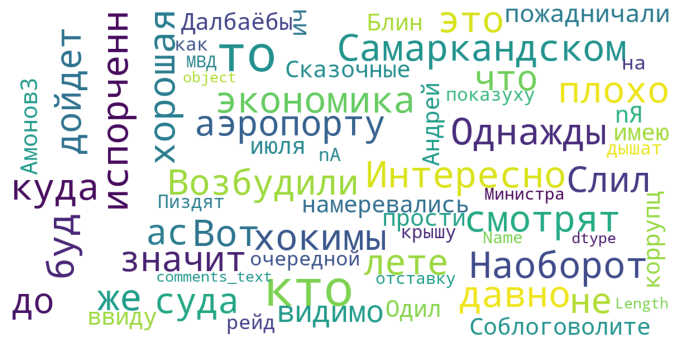

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

df = pd.read_csv('kriminal_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('russian'))   
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(text))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

df_women = df.loc[(df['masc'] == 0) & (df['fem'] == 0)]
df_women['comments_text'] = df_women['comments'].apply(' '.join)


plot_wordcloud(df_women['comments_text'])

In [ ]:
!pip install pyLDAvis

In [93]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 10.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [101]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [114]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models


letters = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')

stop=set(stopwords.words('russian'))
print(stop)

def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('russian'))

    def _preprocess_text(text): 
        corpus=[]       
        for news in text:
            words=[w for w in word_tokenize(news) if (w.lower() not in stop) and (all(np.array([char in letters for char in w.lower()])))]
            corpus.append(words)
        return corpus
    
    text=_preprocess_text(text)

    #text = [d.split() for d in text]
    dic=gensim.corpora.Dictionary(text)
    bow_corpus = [dic.doc2bow(doc) for doc in text]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

{'меня', 'всех', 'какая', 'как', 'из', 'от', 'здесь', 'им', 'об', 'хоть', 'уже', 'один', 'их', 'какой', 'или', 'после', 'них', 'нибудь', 'ничего', 'когда', 'конечно', 'всегда', 'опять', 'то', 'будто', 'ж', 'тебя', 'он', 'другой', 'куда', 'вы', 'тот', 'хорошо', 'вдруг', 'до', 'будет', 'разве', 'перед', 'ее', 'нее', 'еще', 'надо', 'если', 'ни', 'больше', 'было', 'зачем', 'за', 'во', 'ей', 'без', 'но', 'где', 'иногда', 'вот', 'при', 'моя', 'никогда', 'себя', 'между', 'потому', 'и', 'а', 'нет', 'чего', 'ним', 'быть', 'того', 'лучше', 'свою', 'тогда', 'сам', 'сейчас', 'мой', 'нельзя', 'ней', 'много', 'этот', 'нас', 'есть', 'раз', 'бы', 'тут', 'под', 'кто', 'тем', 'три', 'у', 'со', 'чтобы', 'чем', 'да', 'только', 'ну', 'чуть', 'всю', 'мы', 'вам', 'была', 'потом', 'теперь', 'себе', 'почти', 'том', 'к', 'два', 'ведь', 'более', 'все', 'даже', 'него', 'вас', 'можно', 'тоже', 'через', 'этого', 'его', 'такой', 'в', 'может', 'уж', 'про', 'что', 'они', 'впрочем', 'этой', 'не', 'с', 'эти', 'для', 'та

In [ ]:
df = pd.read_csv('kriminal_toxic.csv')
df['comments'] = df['comments'].apply(ast.literal_eval)
df['toxicity'] = df['toxicity'].apply(ast.literal_eval)

df_women = df.loc[(df['masc'] == 0) & (df['fem'] == 0)]
df_women['comments_text'] = df_women['comments'].apply(' '.join)



lda_model, bow_corpus, dic = get_lda_objects(df_women['comments_text'])

In [113]:
plot_lda_vis(lda_model, bow_corpus, dic)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.117534  0.034333       1        1  34.369466
3     -0.076667  0.086406       2        1  27.299560
2     -0.024970 -0.073824       3        1  19.582706
0     -0.015897 -0.046916       4        1  18.748267, topic_info=          Term       Freq      Total Category  logprob  loglift
9          всё  10.000000  10.000000  Default  30.0000  30.0000
958     работу   4.000000   4.000000  Default  29.0000  29.0000
3381        ва   2.000000   2.000000  Default  28.0000  28.0000
436    которые   6.000000   6.000000  Default  27.0000  27.0000
164       мясо   3.000000   3.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
1194       СГБ   1.143552   2.706006   Topic4  -6.6765   0.8127
971   спокойно   1.143012   2.706174   Topic4  -6.6769   0.8122
514    сказать   1.142851   4.690847   Topic4  -6.6771   0.2620
995       дали   1.141535   4.143574   Topic4  -6.6782   0.3849
234       след   1.141391   2.239419   Topic4  -6.6784   1.0001

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1955      4  0.630221   Аптека
3287      3  0.621241    ВЗЯли
2944      3  0.472107      ВОР
2944      4  0.472107      ВОР
3348      3  0.621293  Главаря
...     ...       ...      ...
274       1  0.361291      это
274       2  0.301075      это
274       3  0.180645      это
274       4  0.180645      это
2408      1  0.791552    якобы

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])